In [10]:
import pandas as pd
import numpy as np

# ---------- Read & clean ----------
df = pd.read_excel("ammoniatest4.xlsx", engine="openpyxl")  # <-- key change
df.columns = df.columns.str.strip()          # trim stray spaces

df = df.rename(columns={
    "Sample": "ID",
    "Time":   "Time(biochar char)"
})

# Make sure the two critical columns are present
required_cols = {
    "ID", "run time", "influent mg/m^3", "effluent mg/m^3",
    "Flow Rate", "mass(g)", "Biochar Temp", "Time(biochar char)",
    "Feed", "Room Temp", "Relative Humidity"
}
missing = required_cols.difference(df.columns)
if missing:
    raise ValueError(f"Missing columns in CSV: {missing}")

# ---------- Sort & process ----------
df = df.sort_values(by=["ID", "run time"])

results = []
for sample_id, g in df.groupby("ID"):

    time = g["run time"].to_numpy()                 # min
    Cin  = g["influent mg/m^3"].to_numpy()          # mg/m³
    Cout = g["effluent mg/m^3"].to_numpy()

    Q    = g["Flow Rate"].iloc[0]                   # L/s
    m    = g["mass(g)"].iloc[0]                     # g adsorbent

    # optional: convert L → m³ (1 L = 1e-3 m³) right here:
    adsorbed_mass = Q * 1e-3 * np.trapz(Cin - Cout, x=time)

    q = adsorbed_mass / m                           # mg adsorbed per g

    results.append({
        "ID": sample_id,
        "Adsorption Capacity (mg/g)": q,
        "Pyrolysis Temp (C)":        g["Biochar Temp"].iloc[0],
        "Pyrolysis Time (min)":      g["Time(biochar char)"].iloc[0],
        "Feedstock":                 g["Feed"].iloc[0],
        "Room Temp (C)":             g["Room Temp"].iloc[0],
        "Relative Humidity (%)":     g["Relative Humidity"].iloc[0]
    })

results_df = pd.DataFrame(results)
display(results_df)

,ID,Adsorption Capacity (mg/g),Pyrolysis Temp (C),Pyrolysis Time (min),Feedstock,Room Temp (C),Relative Humidity (%)
0,R-400-30-AD,11.694444,400,30,R,28.5,55.0
1,R-400-60-A,8.629250,400,60,R,19.1,52.0
2,R-400-60-AD,7.370563,400,60,R,18.3,40.0
3,R-500-15-A,7.461300,500,15,R,19.4,62.0
4,R-500-60-A-M1-B,5.075875,500,60,R,21.4,NaN
5,R-500-60-AD,9.054500,500,60,R,21.0,NaN
6,R-600-15-A,4.442900,600,15,R,21.8,0.0
7,R-600-30-AD,7.991174,600,30,R,20.0,52.0
8,R-600-30-AM,6.050975,600,30,R,18.0,52.0
9,WC-400-15-A,7.545014,400,15,WC,19.3,46.0


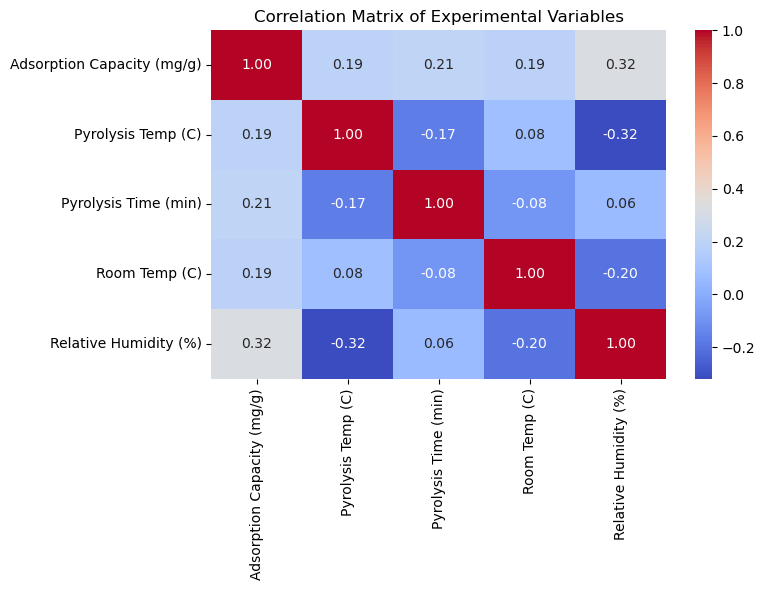

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

###### Correlation Matrix - Both Feedstocks together#############

# Only include numeric columns for correlation
numeric_df = results_df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Experimental Variables')
plt.tight_layout()
plt.show()

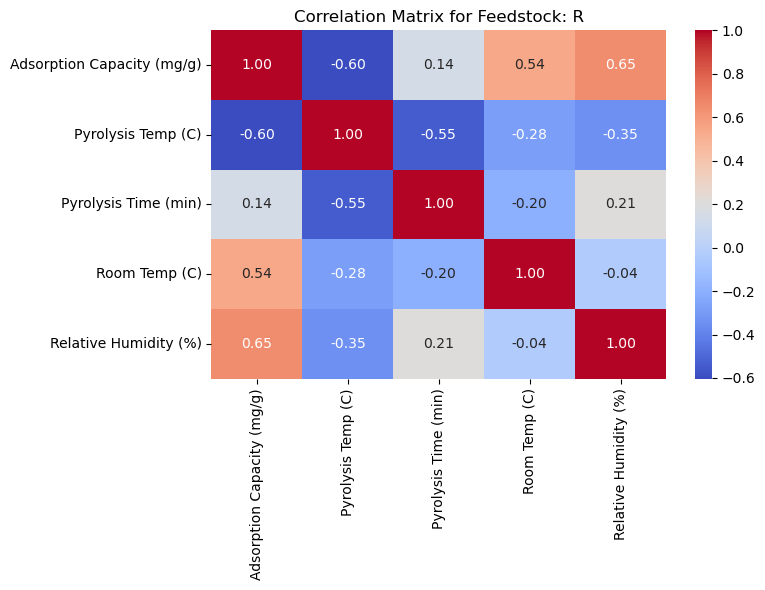

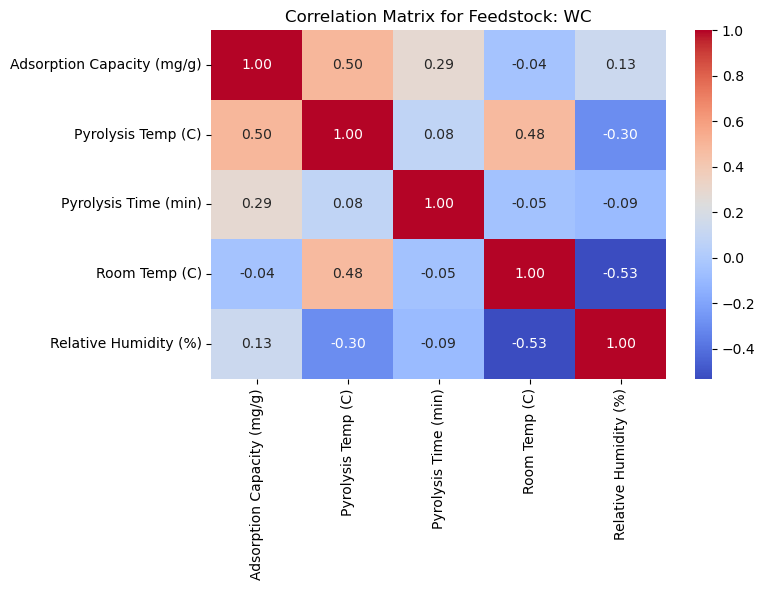

In [12]:
###### Correlation Matrix - Feedstocks separated###########
# Loop through each feedstock type
for feed_type in results_df['Feedstock'].unique():
    # Subset the data for the current feedstock
    subset = results_df[results_df['Feedstock'] == feed_type]
    
    # Only include numeric columns
    numeric_subset = subset.select_dtypes(include=[np.number])
    
    # Compute correlation matrix
    corr_matrix = numeric_subset.corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for Feedstock: {feed_type}')
    plt.tight_layout()
    plt.show()

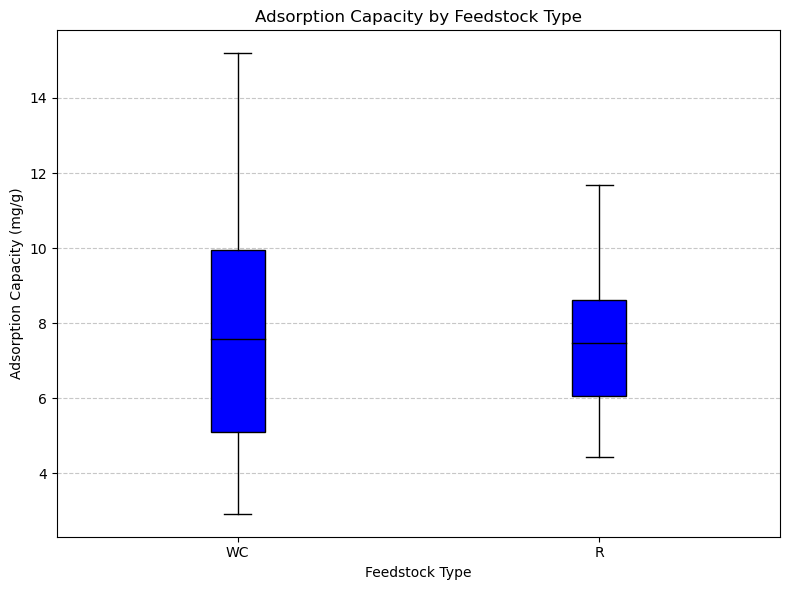

In [13]:
import matplotlib.pyplot as plt

# Group data by feedstock type
wc_data = results_df[results_df['Feedstock'] == 'WC']['Adsorption Capacity (mg/g)']
r_data = results_df[results_df['Feedstock'] == 'R']['Adsorption Capacity (mg/g)']

# Prepare data for boxplot
data   = [wc_data, r_data]
labels = ['WC', 'R']                 # will become the x-tick labels

# Create the boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(
    data,
    labels=labels,                   # <-- the correct kwarg
    patch_artist=True,
    boxprops=dict(facecolor='blue'),
    medianprops=dict(color='black')
)

# Add titles and labels
plt.title('Adsorption Capacity by Feedstock Type')
plt.xlabel('Feedstock Type')
plt.ylabel('Adsorption Capacity (mg/g)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

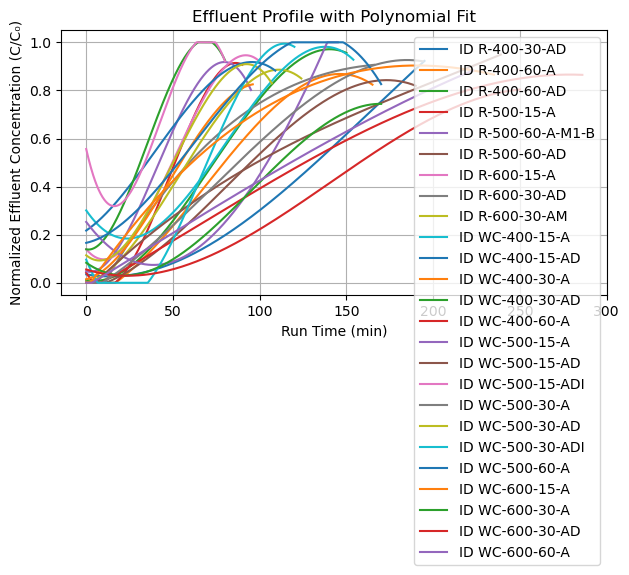

                 ID  adsorption_capacity_mg_per_g
0       R-400-30-AD                     11.744791
1        R-400-60-A                      8.597116
2       R-400-60-AD                      7.401008
3        R-500-15-A                      7.480150
4   R-500-60-A-M1-B                      5.046059
5       R-500-60-AD                      9.060504
6        R-600-15-A                      4.455619
7       R-600-30-AD                      7.791697
8       R-600-30-AM                      6.069239
9       WC-400-15-A                      7.561674
10     WC-400-15-AD                      3.726829
11      WC-400-30-A                      5.499101
12     WC-400-30-AD                      3.171485
13      WC-400-60-A                     12.823208
14     WC-500-15-A                       9.533732
15     WC-500-15-AD                      9.514278
16    WC-500-15-ADI                      2.909330
17      WC-500-30-A                      8.786752
18     WC-500-30-AD                      5.249308


In [14]:
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt


# Clean and prepare data
df = df.sort_values(by=['ID', 'run time'])
df['effluent/influent ratio'] = df['effluent mg/m^3'] / df['influent mg/m^3']   #adds a C/C0 column to dataset
df.dropna(subset=['run time', 'influent mg/m^3', 'effluent mg/m^3'], inplace=True) #drops na data

# Store adsorption results
results = []  #blank results table to store our adsorption capacities

# Loop over each unique sample ID
for sample_id, group in df.groupby('ID'):
    group = group.sort_values('run time')
    x = group['run time'].values  # in minutes
    influent = group['influent mg/m^3'].values  # mg/m³
    effluent = group['effluent mg/m^3'].values  # mg/m³
    flow_rate_L_min = group['Flow Rate'].iloc[0]  # L/min
    biochar_mass_g = group['mass(g)'].iloc[0]  # g

    if len(x) < 4:   #removes any dataset that doesn't have enough data
        print(f"Skipping ID {sample_id}: not enough data for polynomial fitting.")
        continue

    # Fit 3rd-degree polynomial to effluent data
    poly_coeffs = np.polyfit(x, effluent, 3) #fits a 3rd order model
    poly_effluent = np.poly1d(poly_coeffs) #calculate the y-values using fitted parameters

    # Create fine time grid for integration
    x_fine = np.linspace(min(x), max(x), 300)
    effluent_fitted = poly_effluent(x_fine)

    # Clip effluent values if they exceed influent
    influent_mean = np.mean(influent)
    effluent_fitted = np.clip(effluent_fitted, 0, influent_mean)

    # Calculate concentration difference (adsorbed) over time
    adsorbed_conc = influent_mean - effluent_fitted  # mg/m³

    # Flow rate in m³/min
    flow_m3_per_min = flow_rate_L_min / 1000

    # Mass removed at each time step = (adsorbed concentration × flow × dt)
    dt = np.gradient(x_fine)  # minutes
    mass_removed_mg = adsorbed_conc * flow_m3_per_min * dt  # mg

    # Total mass adsorbed = area under the curve
    total_mass_adsorbed_mg = np.sum(mass_removed_mg)

    # Adsorption capacity (mg/g)
    adsorption_capacity = total_mass_adsorbed_mg / biochar_mass_g

    results.append({
        'ID': sample_id,
        'adsorption_capacity_mg_per_g': adsorption_capacity
    })

    # Optional: plot for visual inspection
    plt.plot(x_fine, effluent_fitted / influent_mean, label=f'ID {sample_id}')

plt.xlabel('Run Time (min)')
plt.ylabel('Normalized Effluent Concentration (C/C₀)')
plt.title('Effluent Profile with Polynomial Fit')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Output summary
results_df = pd.DataFrame(results)
print(results_df)

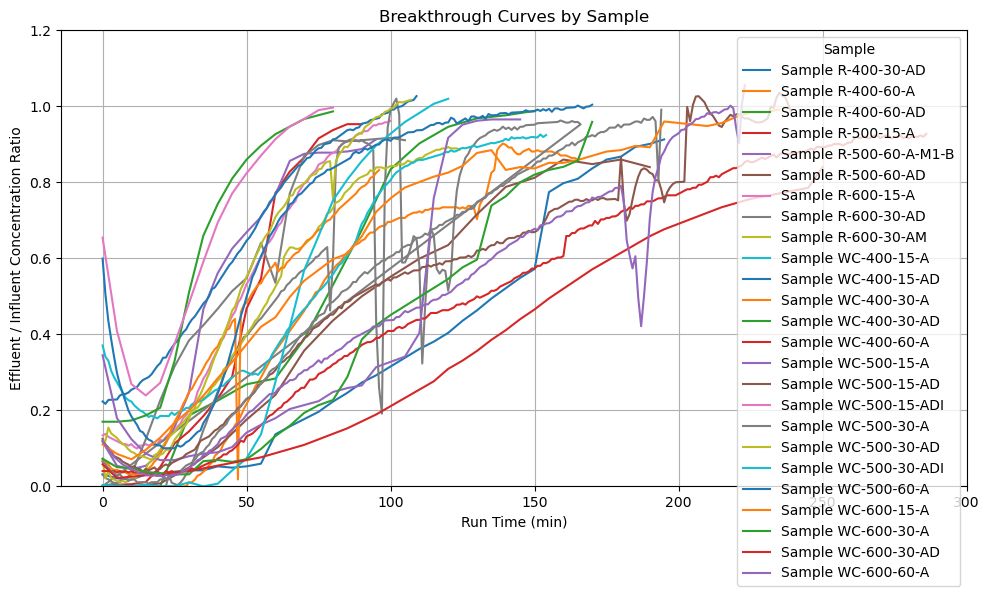

In [15]:
# 1. Read the file
df = pd.read_excel('ammoniatest4.xlsx')
df.columns = df.columns.str.strip()     # tidy up header whitespace

# 2. Use “Sample” as the identifier
df = df.rename(columns={'Sample': 'id'})

# 3. Calculate the effluent / influent ratio
df['effluent/influent ratio'] = (
    df['effluent mg/m^3'] / df['influent mg/m^3']
)

# 4. Plot breakthrough curves, one line per sample
plt.figure(figsize=(10, 6))
for sample_id, group in df.groupby('id'):
    plt.plot(group['run time'],              # x-axis
             group['effluent/influent ratio'],
             label=f'Sample {sample_id}')

plt.xlabel('Run Time (min)')
plt.ylabel('Effluent / Influent Concentration Ratio')
plt.title('Breakthrough Curves by Sample')
plt.ylim(0, 1.2)
plt.legend(title="Sample")
plt.grid(True)
plt.tight_layout()
plt.show()

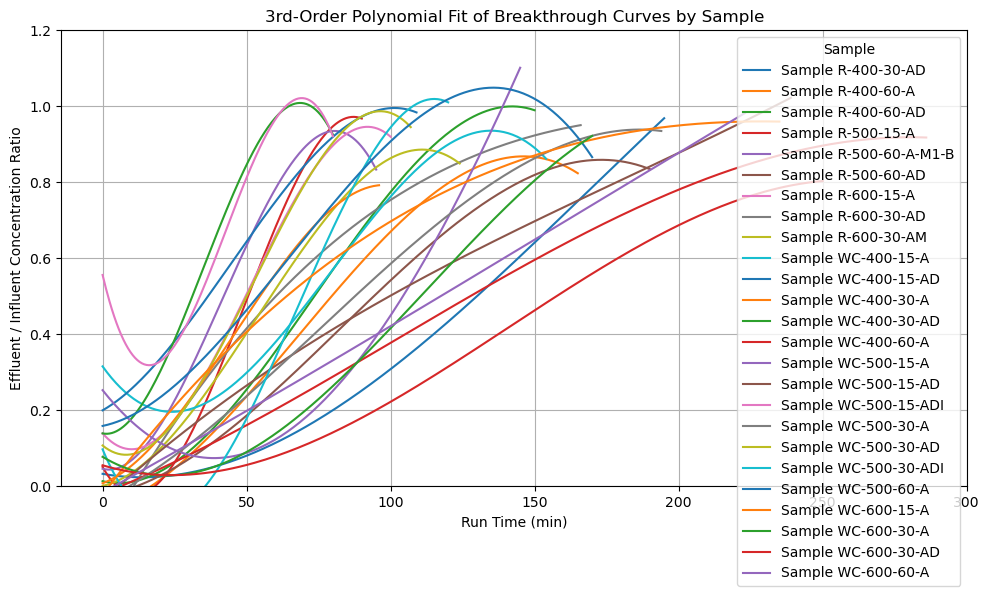

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- 1. Load & clean ----------
df = pd.read_excel('ammoniatest4.xlsx')
df.columns = df.columns.str.strip()          # trim spaces

# Use “Sample” as our ID
df = df.rename(columns={'Sample': 'id'})

# ---------- 2. Derived columns ----------
df['effluent/influent ratio'] = (
    df['effluent mg/m^3'] / df['influent mg/m^3']
)

# ---------- 3. Plot w/ cubic fit ----------
plt.figure(figsize=(10, 6))

for sample_id, group in df.groupby('id'):
    x = group['run time'].values
    y = group['effluent/influent ratio'].values

    # keep only finite pairs
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = x[mask], y[mask]

    if len(x) >= 4:                       # ≥4 points → 3rd-order fit possible
        coeffs = np.polyfit(x, y, 3)
        poly   = np.poly1d(coeffs)

        x_fit = np.linspace(x.min(), x.max(), 200)
        y_fit = poly(x_fit)

        plt.plot(x_fit, y_fit, label=f'Sample {sample_id}')
    else:
        print(f"Skipping Sample {sample_id}: not enough points (need ≥4).")

plt.xlabel('Run Time (min)')
plt.ylabel('Effluent / Influent Concentration Ratio')
plt.title('3rd-Order Polynomial Fit of Breakthrough Curves by Sample')
plt.ylim(0, 1.2)
plt.legend(title='Sample')
plt.grid(True)
plt.tight_layout()
plt.show()

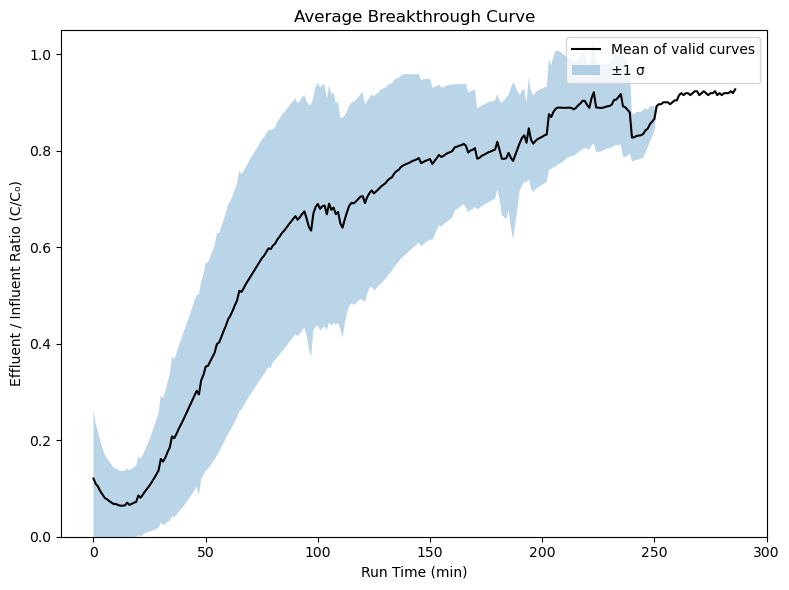

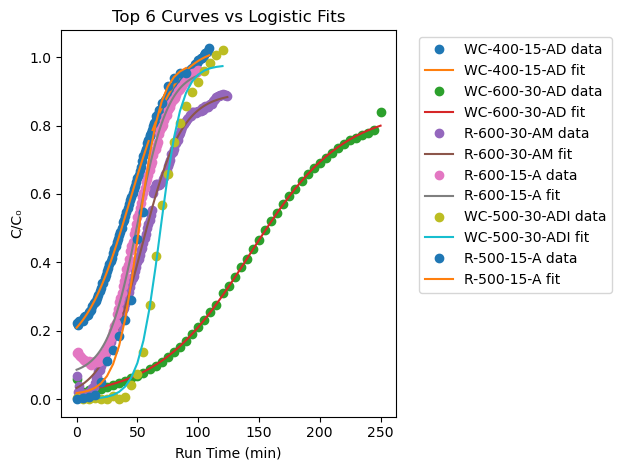

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------- 1 | Load the data ----------
df = pd.read_excel("ammoniatest4.xlsx", engine="openpyxl")
df["ratio"] = df["effluent mg/m^3"] / df["influent mg/m^3"]
df_valid = df[df["Valid: (Y/N)"] == "Y"]

# ---------- 2 | Average curve on a common grid ----------
t_grid = np.arange(0, df_valid["run time"].max() + 1, 1)

def interp_curve(group):
    t, y = group["run time"].values, group["ratio"].values
    idx = np.argsort(t)
    return np.interp(t_grid, t[idx], y[idx], left=np.nan, right=np.nan)

ratio_matrix = np.vstack(df_valid.groupby("Sample").apply(interp_curve).values)
mean_ratio   = np.nanmean(ratio_matrix, axis=0)
std_ratio    = np.nanstd(ratio_matrix, axis=0)

# ---------- 3 | Fit 4-parameter logistic to each curve ----------
def logistic4(t, A, B, k, t0):
    return A + (B - A) / (1 + np.exp(-k * (t - t0)))
#A       | lower asymptote (ratio at $t\to-\infty$; here ≈ initial baseline)
#B       | upper asymptote (plateau value; ideally → 1)                      
#k       | steepness (slope at the inflection point)                         
#t_{0}   | “midpoint time” when the ratio is halfway between $A$ and $B$     


fit_rows = []
for sid, g in df_valid.groupby("Sample"):
    t, y = g["run time"].values, g["ratio"].values
    p0   = [max(0, y.min()), min(1.05, y.max()), 0.05, np.median(t)]
    bounds = ([0, 0.5, 0, 0], [0.5, 1.2, 1, t.max() * 1.5])
    try:
        popt, _ = curve_fit(logistic4, t, y, p0=p0, bounds=bounds, maxfev=20000)
        A, B, k, t0 = popt
        r2 = 1 - np.sum((y - logistic4(t, *popt))**2) / np.sum((y - y.mean())**2)
    except RuntimeError:
        A = B = k = t0 = r2 = np.nan
    fit_rows.append(dict(ID=sid, A=A, B=B, k=k, t0=t0, R2=r2))

fits = pd.DataFrame(fit_rows).sort_values("R2", ascending=False)
fits.to_excel("logistic4_fits.xlsx", index=False)   # handy for later

# ---------- 4 | Visuals ----------
# 4a. Average curve
plt.figure(figsize=(8, 6))
plt.plot(t_grid, mean_ratio, color="black", label="Mean of valid curves")
plt.fill_between(t_grid, mean_ratio - std_ratio, mean_ratio + std_ratio,
                 alpha=0.3, label="±1 σ")
plt.ylim(0, 1.05)
plt.xlabel("Run Time (min)")
plt.ylabel("Effluent / Influent Ratio (C/C₀)")
plt.title("Average Breakthrough Curve")
plt.legend()
plt.tight_layout()
plt.show()

# 4b. Top N logistic fits (change N as you like)
N = 6
for sid in fits.head(N)["ID"]:
    g = df_valid[df_valid["Sample"] == sid]
    t, y = g["run time"].values, g["ratio"].values

    # get the four logistic parameters for this sample
    row = fits.loc[fits["ID"] == sid].iloc[0]
    A, B, k, t0 = row["A"], row["B"], row["k"], row["t0"]

    plt.plot(t, y, "o", label=f"{sid} data")
    plt.plot(t, logistic4(t, A, B, k, t0), "-", label=f"{sid} fit")

plt.xlabel("Run Time (min)")
plt.ylabel("C/C₀")
plt.title(f"Top {N} Curves vs Logistic Fits")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

WC: slope = -0.0054, intercept = 21.6560, R = -0.2380, R² = 0.0566
R: slope = 0.0022, intercept = 19.0500, R = 0.1327, R² = 0.0176


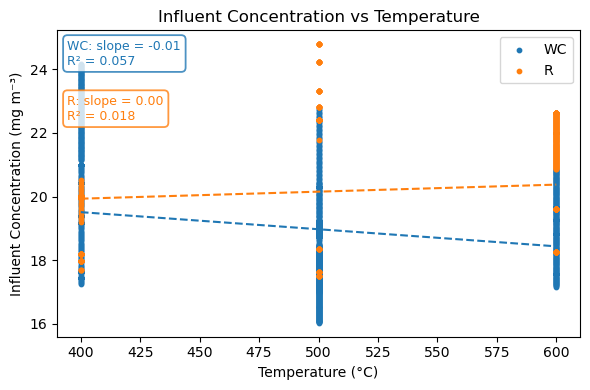

In [37]:
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1) make sure these exist in memory first
feedstocks = {"WC": "tab:blue", "R": "tab:orange"}
df_valid   = df[df["Valid: (Y/N)"] == "Y"]            # or however you created it

# ------------------------------------------------------------------
# 2) plot with slope and R
plt.figure(figsize=(6,4))

for i, (feed, color) in enumerate(feedstocks.items()):
    sub = df_valid[df_valid["Feed"] == feed]
    if len(sub) < 2:          # need at least 2 points for a regression
        continue

    # scatter
    plt.scatter(sub["Biochar Temp"], sub["influent_conc"],
                label=feed, c=color, marker="o",
                facecolors="none", linewidths=1, s=10)

    # regression
    res   = linregress(sub["Biochar Temp"], sub["influent_conc"])
    slope = res.slope
    intercept = res.intercept
    r     = res.rvalue

    xx = np.linspace(sub["Biochar Temp"].min(), sub["Biochar Temp"].max(), 100)
    plt.plot(xx, slope*xx + intercept, linestyle="--", color=color)

    # ── NEW ANNOTATION BLOCK ──────────────────────────────────────
    # Build the two-line text string
    stat_txt = f"{feed}: slope = {slope:.2f}\nR² = {r**2:.3f}"

    # Vertical slot for each feed so the boxes don’t overlap
    y_slot = 0.97 - i*0.18        # 0.18 ≈ box height; tweak if needed

    plt.text(0.02, y_slot, stat_txt, transform=plt.gca().transAxes,
             fontsize=9, ha="left", va="top", color=color,
             bbox=dict(boxstyle="round,pad=0.35",
                       facecolor="white", alpha=0.8,
                       edgecolor=color, linewidth=1.3))

    # console printout
    print(f"{feed}: slope = {slope:.4f}, intercept = {intercept:.4f}, "
          f"R = {r:.4f}, R² = {r**2:.4f}")

plt.xlabel("Temperature (°C)")
plt.ylabel("Influent Concentration (mg m⁻³)")
plt.title("Influent Concentration vs Temperature")
plt.legend()
plt.tight_layout()
plt.show()

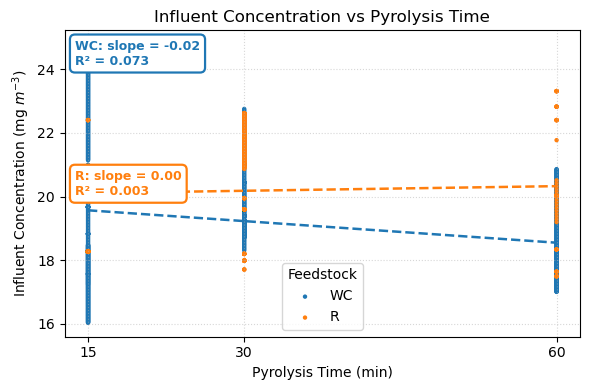

In [42]:
# Identify pyrolysis‑time column (column D)
TIME_COL = None
for col in ["Time", "run time"]:
    if col in df.columns:
        TIME_COL = col
        break
if TIME_COL is None:                         # fallback = 4th column
    TIME_COL = df.columns[3]

# Ensure numeric time (handles strings like "15 min")
df[TIME_COL] = pd.to_numeric(
    df[TIME_COL].astype(str).str.extract(r"(\d+\.?\d*)")[0],
    errors="coerce"
)

# Y‑axis column
if "influent mg/m^3" in df.columns:
    y_col = "influent mg/m^3"
else:
    y_col = next(c for c in df.columns if "influent" in c.lower())

df["influent_conc"] = df[y_col]

# Keep only valid rows, if flag exists
if "Valid: (Y/N)" in df.columns:
    df_valid = df[df["Valid: (Y/N)"].eq("Y")]
else:
    df_valid = df

# ---------------------------------------------------------------
# Plot
feedstocks = {"WC": "tab:blue", "R": "tab:orange"}
fig, ax = plt.subplots(figsize=(6, 4))

# 1)  Point & line aesthetics   (put these near the top once)
# -------------------------------------------
# PREP (put these once, before the loop)
feedstocks = {"WC": "tab:blue", "R": "tab:orange"}
x_col      = TIME_COL            # or "Biochar Temp"
y_col      = "influent_conc"
marker_kw  = dict(marker="o", s=10, edgecolors="none")
line_kw    = dict(linestyle="--", linewidth=1.8)
# -------------------------------------------

n_feeds = len(feedstocks)        # how many boxes to stack
for idx, (feed, color) in enumerate(feedstocks.items()):
    sub = df_valid[df_valid["Feed"] == feed]
    if sub.empty:
        continue

    # ▸ All datapoints
    ax.scatter(sub[x_col], sub[y_col],
               color=color, label=feed, **marker_kw)

    # ▸ Regression line (kept out of legend)
    lr = linregress(sub[x_col], sub[y_col])
    m, b, r = lr.slope, lr.intercept, lr.rvalue
    xx = np.linspace(sub[x_col].min(), sub[x_col].max(), 200)
    ax.plot(xx, m*xx + b, color=color, **line_kw, label="_nolegend_")

    # ▸ Stats box — auto-spaced so boxes never overlap
    y_slot = 0.97 - idx * (0.85 / n_feeds)   # 0.85 ≈ usable top margin
    txt    = f"{feed}: slope = {m:.2f}\nR² = {r**2:.3f}"
    ax.text(0.02, y_slot, txt,
            transform=ax.transAxes,
            ha="left", va="top", fontsize=9, fontweight="bold",
            color=color,
            bbox=dict(boxstyle="round,pad=0.4",
                      facecolor="white",
                      edgecolor=color, linewidth=1.6))

ax.legend(title="Feedstock")

# Axis labels & title
ax.set_xlabel("Pyrolysis Time (min)")
ax.set_ylabel("Influent Concentration (mg $m^{-3}$)")
ax.set_title("Influent Concentration vs Pyrolysis Time")
ax.set_xticks([15, 30, 60])
ax.legend(title="Feedstock")
ax.grid(True, linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()

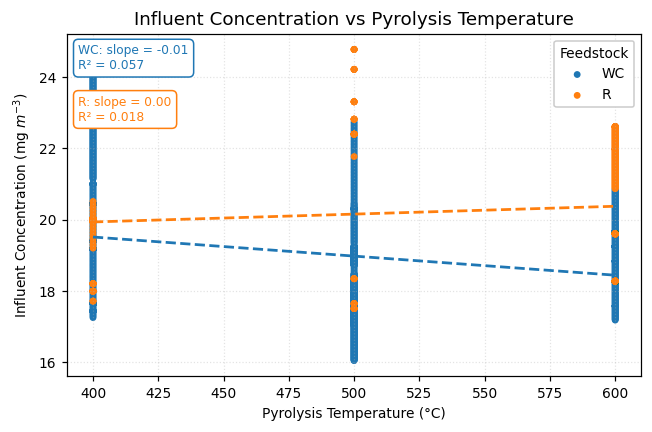

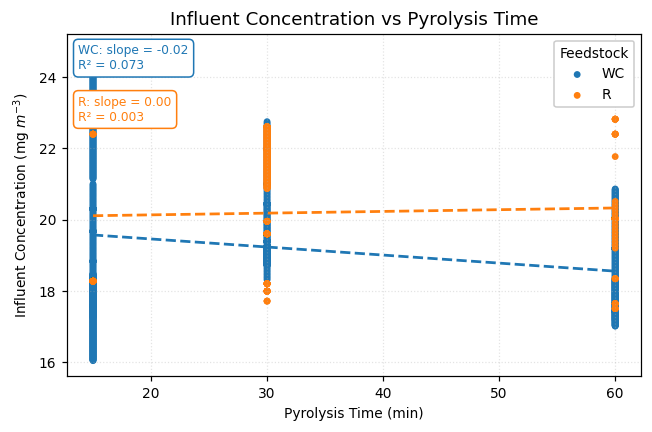

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ------------------------------------------------------------
# GLOBAL STYLE (only run once per notebook / script)
plt.rcParams.update({
    "font.size": 9,
    "axes.titlesize": 12,
    "axes.labelsize": 9,
    "legend.fontsize": 9,
    "figure.dpi": 110,
})

FEED_COLOURS = {"WC": "tab:blue", "R": "tab:orange"}
MARKER_KW    = dict(marker="o", s=20, edgecolors="none")
LINE_KW      = dict(linestyle="--", linewidth=1.8)

# ------------------------------------------------------------
def influent_plot(df, x_col, title, x_label):
    """
    Make a scatter + OLS line plot with identical styling.
    
    Parameters
    ----------
    df      : DataFrame already filtered to valid rows
    x_col   : string – x-axis column in df
    title   : string – plot title
    x_label : string – x-axis label
    """
    y_col = "influent_conc"            # helper column you created earlier
    fig, ax = plt.subplots(figsize=(6, 4))

    n_feeds = len(FEED_COLOURS)
    for idx, (feed, colour) in enumerate(FEED_COLOURS.items()):
        sub = df[df["Feed"] == feed]
        if sub.empty:
            continue

        # ◉ all data points
        ax.scatter(sub[x_col], sub[y_col], color=colour,
                   label=feed, **MARKER_KW)

        # — best-fit line (kept out of legend) —
        lr = linregress(sub[x_col], sub[y_col])
        m, b, r = lr.slope, lr.intercept, lr.rvalue
        xx = np.linspace(sub[x_col].min(), sub[x_col].max(), 200)
        ax.plot(xx, m*xx + b, color=colour, label="_nolegend_", **LINE_KW)

        # ▢ stats box, evenly spaced
        y_slot = 0.97 - idx * 0.15
        txt    = f"{feed}: slope = {m:.2f}\nR² = {r**2:.3f}"
        ax.text(0.02, y_slot, txt, transform=ax.transAxes,
                ha="left", va="top", fontsize=8,
                color=colour,
                bbox=dict(boxstyle="round,pad=0.4",
                          facecolor="white", edgecolor=colour,
                          linewidth=1.0))

    # --- axis / legend / grid ---
    ax.set_xlabel(x_label)
    ax.set_ylabel("Influent Concentration (mg $m^{-3}$)")
    ax.set_title(title)
    ax.legend(title="Feedstock", loc="upper right", framealpha=1)
    ax.grid(True, linestyle=":", alpha=0.35)
    plt.tight_layout()
    return fig, ax

# 1️⃣  Temperature plot
fig1, ax1 = influent_plot(
    df_valid,                     # dataframe already filtered to Valid = Y
    x_col="Biochar Temp",         # temperature column
    title="Influent Concentration vs Pyrolysis Temperature",
    x_label="Pyrolysis Temperature (°C)"
)

# 2️⃣  Pyrolysis-time plot
fig2, ax2 = influent_plot(
    df_valid,
    x_col=TIME_COL,               # the cleaned numeric “Time” column
    title="Influent Concentration vs Pyrolysis Time",
    x_label="Pyrolysis Time (min)"
)

plt.show()    # show both if running in a script; Jupyter shows automatically